Max safe pitch as a function of vertical FOV

$$ \psi_{\text{max}} = \frac{FOV_{vertical}}{2} $$

Due to the dynamics of a quadrotor (refer to Mellinger), a maximum allowable pitch is directly mapped to a maximum allowable deceleration:

$$ a_{max} = g \tan \bigg( \frac{FOV_{vetical}}{2} \bigg)$$

A maximum allowable deceleration defines the maximum stopping distance, for a given speed.  In order to keep the maximum stopping distance inside of the maximum depth range, then the allowable speed must be limited.  With a simple double-integrator approximation of the quadrotor dynamics, solving $p(t) = \frac{1}{2}at2 + v_0t$ and $v(t) = at + v_0$ for $t = \frac{-v_0}{a}$ gives the following:

$$ v_0 = \sqrt{\frac{2pa}{3}}$$

Note that we've ommitted the negative sign which just represents that $a$ is opposite to the vector $p$.

This gives the maximum allowable speed directly as a function of the depth camera used.  $p$ is the stopping distance, which to maintain safe flight must be less than the maximum depth sensor range.  

We now have a function that relates the two of the key characteristics of a depth camera, the vertical FOV and the range, to the maximum allowable speed in forward flight:

$$ v_{max} = \sqrt{ \frac{2 d_{max} g}{3}\tan\bigg( \frac{FOV_{vertical}}{2} \bigg)} $$

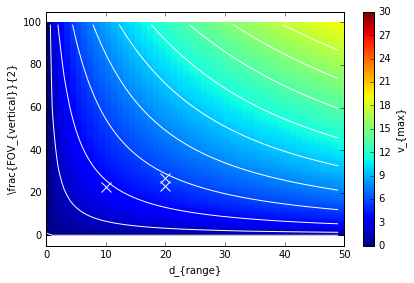

In [9]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
%matplotlib inline

def f(dmax,fov_vertical):
    fov_vertical = fov_vertical * np.pi/180.0
    return np.sqrt(2*dmax*9.8/3*np.tan(fov_vertical/2))

# dmax
xmin = 0
xmax = 50

# fov_vertical
ymin = 0
ymax = 100

z = numpy.array([[f(x, y) for x in range(xmin,xmax)] for y in range(ymin,ymax)])

plt.pcolormesh(z, vmin=0, vmax=30)
plt.colorbar(label='v_{max}')
curves = 10
m = max([max(row) for row in z])
levels = numpy.arange(0, m, (1 / float(curves)) * m)
plt.contour(z, colors="white", levels=levels)
plt.xlabel(r'd_{range}')
plt.ylabel(r'\frac{FOV_{vertical}}{2}')
sensor_data_x = [10,20,20] # xtion, realsense r200, zed
sensor_data_y = [45,46,54]
for i,v in enumerate(sensor_data_y):
    sensor_data_y[i] = v/2.0 
plt.scatter(sensor_data_x,sensor_data_y,marker='x',color='white',s=100)
axes = plt.gca()
axes.set_xlim([0,50])
plt.tight_layout()
plt.savefig('sensors.pdf')
plt.show()

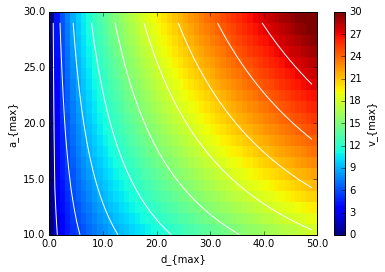

In [106]:
def f2(dmax,amax):
    return np.sqrt(2*dmax*amax/3)

# dmax
xmin = 0
xmax = 50

# amax
ymin = 10
ymax = 30

xbins = np.arange(xmin,xmax,1.0)
ybins = np.arange(ymin,ymax,1.0)
z = numpy.array([[f2(x, y) for x in xbins] for y in ybins])

plt.pcolormesh(z, vmin=0, vmax=30)

num_ticks = float(5)
xtick_locs = np.arange(0,len(xbins)+1,len(xbins)/num_ticks)
xtick_labels = np.arange(xmin,xmax+1,(xmax-xmin)/num_ticks)
plt.xticks(xtick_locs, xtick_labels)

num_ticks = float(4)
ytick_locs = np.arange(0,len(ybins)+1,len(ybins)/num_ticks)
ytick_labels = np.arange(ymin,ymax+1,(ymax-ymin)/num_ticks)
plt.yticks(ytick_locs, ytick_labels)

plt.colorbar(label='v_{max}')
curves = 10
m = max([max(row) for row in z])
levels = numpy.arange(0, m, (1 / float(curves)) * m)
plt.contour(z, colors="white", levels=levels)
plt.xlabel('d_{max}')
plt.ylabel('a_{max}')
plt.show()

Interestingly, though, only a small amount of memory is needed in order to enable the vehicle to be limited by its actuators rather than by its current FOV.

In particular, if we simply calculate the stopping time for the simple double integrator as a function of speed and acceleration ($t = \frac{v_0}{a}$) we get:




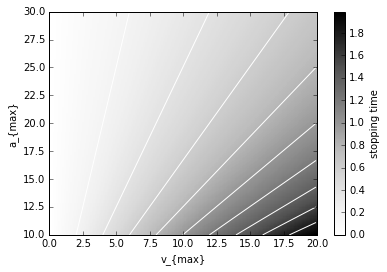

In [289]:
def stopping_time(vmax,amax):
    return vmax/amax

# vmax
xmin = 0
xmax = 20

# amax
ymin = 10
ymax = 30

xbins = np.arange(xmin,xmax,0.1)
ybins = np.arange(ymin,ymax,0.1)
z = numpy.array([[stopping_time(x, y) for x in xbins] for y in ybins])

plt.pcolormesh(z, cmap=plt.get_cmap('Greys'))

num_ticks = float(8)
xtick_locs = np.arange(0,len(xbins)+1,len(xbins)/num_ticks)
xtick_labels = np.arange(xmin,xmax+1,(xmax-xmin)/num_ticks)
plt.xticks(xtick_locs, xtick_labels)

ytick_locs = np.arange(0,len(ybins)+1,len(ybins)/num_ticks)
ytick_labels = np.arange(ymin,ymax+1,(ymax-ymin)/num_ticks)
plt.yticks(ytick_locs, ytick_labels)

plt.colorbar(label='stopping time')
curves = 10
m = max([max(row) for row in z])
levels = numpy.arange(0, m, (1 / float(curves)) * m)
plt.contour(z, colors="white", levels=levels)
plt.xlabel('v_{max}')
plt.ylabel('a_{max}')
plt.show()

It is interesting to note that we acually don't even need much memory at all.

In addition to the relatively short depth of memory needed, it is often the case in certain regimes of motion that there is a large bias towards the very most recent measurement being sufficient.

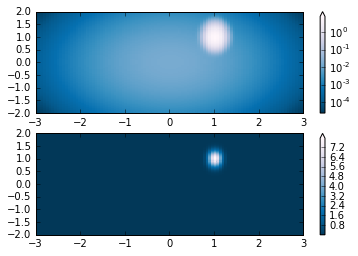

In [108]:
"""
Demonstration of using norm to map colormaps onto data in non-linear ways.
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

'''
Lognorm: Instead of pcolor log10(Z1) you can have colorbars that have
the exponential labels using a norm.
'''
N = 100
X, Y = np.mgrid[-3:3:complex(0, N), -2:2:complex(0, N)]

# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale so we see both hump and spike.  linear
# scale only shows the spike.
Z1 = bivariate_normal(X, Y, 0.1, 0.2, 1.0, 1.0) +  \
    0.1 * bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)

fig, ax = plt.subplots(2, 1)

pcm = ax[0].pcolor(X, Y, Z1,
                   norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()),
                   cmap='PuBu_r')
fig.colorbar(pcm, ax=ax[0], extend='max')

pcm = ax[1].pcolor(X, Y, Z1, cmap='PuBu_r')
fig.colorbar(pcm, ax=ax[1], extend='max')
fig.show()

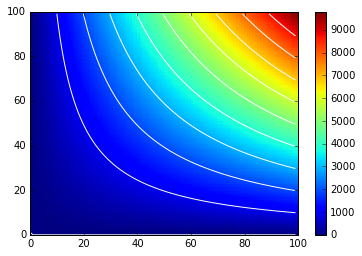

In [109]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

def f(x, y):
  return x*y

xmax = ymax = 100
z = numpy.array([[f(x, y) for x in range(xmax)] for y in range(ymax)])

plt.pcolormesh(z)
plt.colorbar()
curves = 10
m = max([max(row) for row in z])
levels = numpy.arange(0, m, (1 / float(curves)) * m)
plt.contour(z, colors="white", levels=levels)
plt.show()

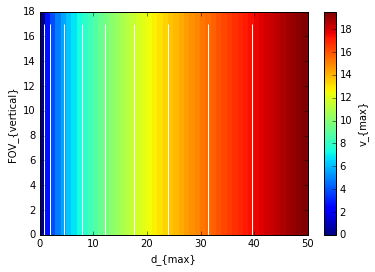

In [110]:
def f2(dmax,fov_vertical):
    fov_vertical = 100 * np.pi/180.0
    return np.sqrt(2*dmax*9.8/3*np.tan(fov_vertical/2))

# dmax
xmin = 0
xmax = 50

# amax
ymin = 2
ymax = 20

z = numpy.array([[f2(x, y) for x in range(xmin,xmax)] for y in range(ymin,ymax)])

plt.pcolormesh(z)
plt.colorbar(label='v_{max}')
curves = 10
m = max([max(row) for row in z])
levels = numpy.arange(0, m, (1 / float(curves)) * m)
plt.contour(z, colors="white", levels=levels)
plt.xlabel('d_{max}')
plt.ylabel('FOV_{vertical}')
plt.show()

In [111]:
print np.arange(1,11)
print np.arange(10,0,-1)


[ 1  2  3  4  5  6  7  8  9 10]
[10  9  8  7  6  5  4  3  2  1]


(3, 10)
(10,)


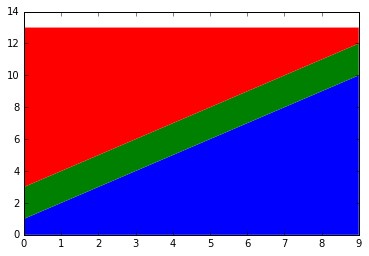

In [127]:
import numpy as np
import matplotlib.pyplot as plt

def fnx():
    return np.ones(10)
    a = np.random.randint(5, 50, 10)
    
def fnxup():
    return np.arange(1,11)

def fnxdown():
    return np.arange(10,0,-1)
    
y = np.row_stack((fnxup(), 2*fnx(), fnxdown()))
x = np.arange(10)

print np.shape(y)
print np.shape(x)

fig, ax = plt.subplots()
ax.stackplot(x, y, colors=('b','g','r'),edgecolor='none')
plt.show()

#y1, y2, y3 = fnx(), fnx(), fnx()
# fig, ax = plt.subplots()
# ax.stackplot(x, y1, y2, y3)
# plt.show()

YlGn


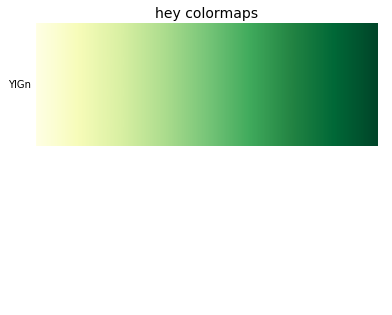

In [225]:
import numpy as np
import matplotlib.pyplot as plt


# Have colormaps separated into categories:
# http://matplotlib.org/examples/color/colormaps_reference.html
cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]




nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        print name
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()


cmap_mine = ['YlGn']
plot_color_gradients("hey", cmap_mine, 2)
        
#for cmap_category, cmap_list in cmaps:
#    plot_color_gradients(cmap_category, cmap_list, nrows)

plt.show()

In [226]:
import matplotlib.cm as cm
colors = cm.nipy_spectral(np.linspace(0, 1, 12))
print colors
colors = cm.YlGn(np.linspace(0, 1, 12))
#print np.flip(colors, 0) # flip to return green to yellow

[[ 0.          0.          0.          1.        ]
 [ 0.52024118  0.          0.58692157  1.        ]
 [ 0.          0.          0.78826863  1.        ]
 [ 0.          0.52158824  0.8667      1.        ]
 [ 0.          0.6667      0.62746471  1.        ]
 [ 0.          0.61306863  0.          1.        ]
 [ 0.          0.85362157  0.          1.        ]
 [ 0.51762353  1.          0.          1.        ]
 [ 0.97253529  0.85488824  0.          1.        ]
 [ 1.          0.36470588  0.          1.        ]
 [ 0.85362157  0.          0.          1.        ]
 [ 0.8         0.8         0.8         1.        ]]


In [227]:
# Synthetic data about how recent everything is

def sample_n(n):
    mu, sigma = 0, 10 # mean and standard deviation
    s = np.random.normal(mu, sigma, n)
    for i, val in enumerate(s):
        if s[i] < 0:
            s[i] = -1
        else:
            s[i] = int(abs(s[i]))
    return s


A = np.ones((1000,100))

#rows is time
#column is how far back had to search for each motion planning query

# for i, rowval in enumerate(A):
#     for j, val in enumerate(rowval):
#         A[i,j] = 2.0
       
for i, rowval in enumerate(A):
    A[i] = sample_n(100)
    
print A
print np.shape(A)
        

[[ -1.   1.  -1. ...,  -1.  -1.   2.]
 [ -1.  -1.  -1. ...,  -1.  13.  -1.]
 [ -1.  -1.  -1. ...,   6.   1.  -1.]
 ..., 
 [ -1.  -1.  -1. ...,   8.  -1.   0.]
 [  3.  -1.  -1. ...,   9.   7.   5.]
 [  9.  -1.  -1. ...,   6.  -1.  -1.]]
(1000, 100)


In [228]:
a = np.array([0,0,0,1])
unique, counts = np.unique(a, return_counts=True)
print unique
print counts
count_dict = dict(zip(unique, counts))

for i in range(4):
    if i in count_dict:
        print count_dict[i]
    else:
        print 0

[0 1]
[3 1]
3
1
0
0


In [264]:
n = 151 # including out-of-FOV
fname = "histogramdata.txt"
with open(fname) as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
histogram_data = []
histogram_times = []
time_index = -1
empty_row = np.zeros(151)
for i in range(len(content)):
    split_content = content[i].split()
    if (len(split_content) == 1):
        time_index += 1
        histogram_data.append(np.zeros(151))
        histogram_times.append(split_content[0])
        continue
    history_number = int(split_content[0])
    number_queries = split_content[1]
    row = histogram_data[time_index]
    if (row[history_number] != 0):
        print "error!"
        print time_index, "time_index"
        print history_number, "history_number"
        print row[history_number]
        break
    row[history_number] = number_queries

print len(histogram_data)
print len(histogram_times)
first_time = float(histogram_times[0])*1.0
for i in range(len(histogram_times)):
    histogram_times[i] = float(histogram_times[i]) - first_time

892
892


(892, 151)
(892,)


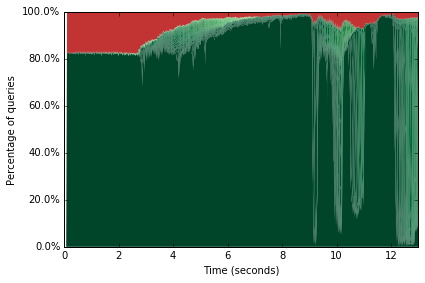

In [265]:
# change into percentage

max_depth = 150 + 1 # add one for not in view
percentages = np.ones((len(histogram_data),max_depth))

for i, rowval in enumerate(histogram_data):
    percentage = np.zeros(max_depth)
    for j, val in enumerate(percentage):
        percentage[j] = rowval[j]
    if (np.sum(percentage) == 0):
        percentages[i] = percentage
        continue
    percentage = percentage / np.sum(percentage)
    percentages[i] = percentage 


x = np.arange(len(histogram_data))
percentages = percentages.transpose()
print np.shape(percentages.transpose())
print np.shape(x)

def flip_0_axis(two_d_array):
    copy = two_d_array * 1.0
    length = len(two_d_array)
    for i in range(length):
        copy[length-1-i] = two_d_array[i]
    return copy
        

my_colormap = cm.YlGn(np.linspace(0, 1, max_depth))
my_colormap = flip_0_axis(my_colormap)
#my_colormap = np.flip(my_colormap, 0) # flip to return green to yellow
my_colormap[max_depth-1] = [180.0/256, 0., 0., 0.8]

fig, ax = plt.subplots()
ax.stackplot(histogram_times, percentages, colors = my_colormap,edgecolor='none')
plt.xlabel('Time (seconds)')
plt.ylabel('Percentage of queries')
plt.gca().yaxis.set_major_formatter(formatter)
axes = plt.gca()
axes.set_xlim([0,13])
axes.set_ylim([0,1])
plt.tight_layout()
plt.savefig('hist_over_time.pdf')
plt.show()

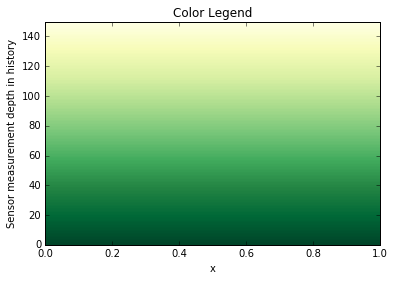

In [267]:
x = [0,1]

legend_data = []
for i in range(150):
    legend_data.append([1,1])

plt.stackplot(x, legend_data, colors=my_colormap,edgecolor='none')

plt.xlabel('x')
plt.ylabel('Sensor measurement depth in history')
plt.title('Color Legend')
plt.legend()
axes = plt.gca()
axes.set_ylim([0,150])
plt.show()

In [268]:
x = [0,1]

legend_data = []
for i in range(150):
    legend_data.append([1,1])

[ 0.703125  0.        0.        0.8     ]
2
150


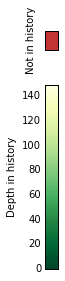

In [269]:
from matplotlib import gridspec

red_data = [1,1]

print my_colormap[-1]

# plot it
fig = plt.figure(figsize=(1, 4)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 10]) 
ax0 = plt.subplot(gs[0])
ax0.stackplot(x, red_data, colors=[my_colormap[-1]],edgecolor='none')
ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.set_xticklabels([])
ax0.set_yticklabels([])


ax1 = plt.subplot(gs[1])
print len(x)
print len(legend_data)
ax1.stackplot(x, legend_data, colors=my_colormap,edgecolor='none')
ax1.set_xticklabels([])

plt.legend()
#ax0.set_title("Color legend")
ax0.set_ylabel('Not in history')
ax1.set_ylabel('Depth in history')
ax1.tick_params(axis=u'both', which=u'both',length=0)
axes = plt.gca()
axes.set_ylim([0,149])

plt.tight_layout()
plt.savefig('color_labels.pdf')

[-0.0627732   0.3802835   0.92609853 ..., -0.76944813  0.33684164
 -0.19262967]


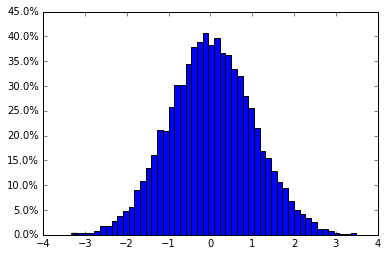

In [270]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

x = randn(5000)
print x

# Make a normed histogram. It'll be multiplied by 100 later.
plt.hist(x, bins=50, normed=True)

# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [271]:
# one histogram

summary_histogram_data = np.zeros(151)
for i,rowval in enumerate(histogram_data):
    for j,val in enumerate(rowval):
        summary_histogram_data[j] += val

each_histogram_data = []
for i,v in enumerate(summary_histogram_data):
    for j in range(int(v)):
        each_histogram_data.append(i)

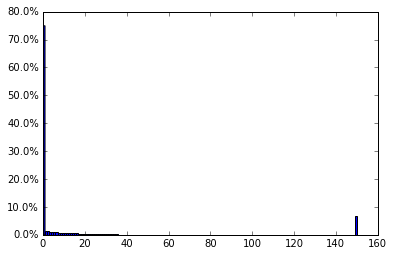

In [272]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'


# Make a normed histogram. It'll be multiplied by 100 later.
plt.hist(each_histogram_data, bins=151, normed=True)

# Create the formatter using the function to_percent. This multiplies all the
# default labels by 100, making them all percentages
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

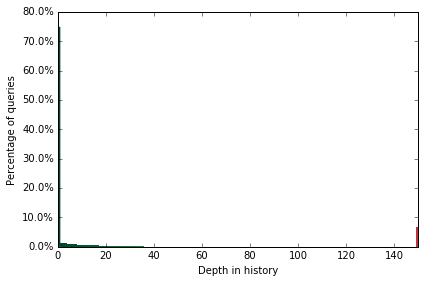

In [290]:
import numpy as n
import matplotlib.pyplot as plt

# Random gaussian data.
Ntotal = 1000
data = n.random.rand(Ntotal)*150

# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('YlGn')
#colors = cm.YlGn(np.linspace(0, 1, 12))
#print np.flip(colors, 0) # flip to return green to yellow

# Plot histogram.
n, bins, patches = plt.hist(each_histogram_data, 151, color='red',normed=True,edgecolor='none')
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

i = 0
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', my_colormap[i])
    i += 1
    
formatter = FuncFormatter(to_percent)

# Set the formatter
plt.gca().yaxis.set_major_formatter(formatter)
axes = plt.gca()
axes.set_xlim([0,150])
plt.xlabel('Depth in history')
plt.ylabel('Percentage of queries')
plt.tight_layout()
plt.savefig('hist_over_time.pdf')    
plt.show()

In [274]:
print sum(summary_histogram_data)

883131.0


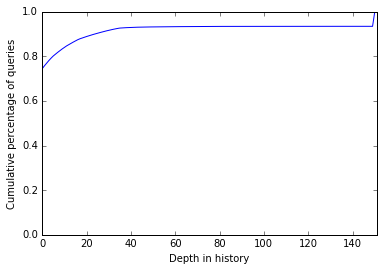

In [284]:
ratio_hist_data = summary_histogram_data/sum(summary_histogram_data)

cumulative = []
for i,v in enumerate(ratio_hist_data):
    if (i == 0):
        cumulative.append(v)
        continue
    cumulative.append(cumulative[i-1] + v)
    
plt.plot(cumulative)
axes = plt.gca()
axes.set_xlim([0,151])
axes.set_ylim([0,1])
plt.xlabel('Depth in history')
plt.ylabel('Cumulative percentage of queries')
plt.show()